In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import scipy.stats
import statsmodels.api as sm
from sklearn.linear_model import SGDRegressor
from ggplot import *

Lodaing data

In [5]:
weather = pd.read_csv('data.csv');
weather_regress = pd.read_csv('data_regress.csv');

Extract two dataframe with respect to with or without fog

In [6]:
fog = weather.loc[weather.fog == 1, 'Entries_num_hourly']
nonfog = weather.loc[weather.fog == 0, 'Entries_num_hourly']

Here we look at some statistic property, like mean and std of number of entries

In [7]:
fog_mean = np.mean(fog)
nonfog_mean = np.mean(nonfog)
fog_std = np.std(fog)
nonfog_std = np.std(nonfog)
print ('The mean of entries with fog is ' + str(fog_mean))
print ('The mean of entries without fog is ' + str(nonfog_mean))
print ('The std of entries with fog is ' + str(fog_std))
print ('The std of entries without fog is ' + str(nonfog_std))

The mean of entries with fog is 1154.6593496303688
The mean of entries without fog is 1083.449282087678
The std of entries with fog is 2474.036823679882
The std of entries without fog is 2308.3520393684516


Then we define two kinds of linear regression model to train the data

In [8]:
def linear_regression(features, values):
    features = sm.add_constant(features)
    model = sm.OLS(values, features)
    results = model.fit()
    intercept = results.params[0]
    parameters = results.params[1:]
    return intercept, parameters

def linear_regression_SGD(features, values):
    model = SGDRegressor()
    model.fit(features, values)
    intercept = model.intercept_
    parameters = model.coef_
    return intercept, parameters

We select some features which might influence the number of entries


In [9]:
features = weather_regress[['fog','meantempi','station','conditions','day_week','hour']]
f = pd.get_dummies(features)
v = weather_regress['Entries_num_hourly']

We apply the linear model in statemodels and predict the values

In [10]:
#Implemet linear regression
i_sm, p_sm = linear_regression(f, v)
#Predicted values form the regression equation.
p_sm = i_sm + np.dot(f, p_sm)

Handling(normlizing) data to fit the linear model 

In [11]:
def norm_features(features):
    means = np.mean(features, axis=0)
    std = np.std(features, axis=0)
    norm_features = (features - means) / std
    return means, std, norm_features

Linear regression with SGDRegressor in linear model and make the prediction

In [12]:
# Get numpy arrays
features_array = f.values
values_array = v.values
means, std, norm_features_array = norm_features(features_array)

# Perform gradient descent
norm_i, norm_p = linear_regression_SGD(norm_features_array, values_array)
i_SGD = norm_i - np.sum(means * norm_p / std)
p_SGD = norm_p / std
p_SGD = i_SGD + np.dot(features_array, p_SGD)

We are going to analyze the residual error to check how well the model can fit the data

In [13]:
def residual(data,predictions):
    fig = plt.figure()
    axis = fig.add_subplot(111);
    fig.suptitle('Residual')
    axis.set_xlabel('Residual Error')
    axis.set_ylabel('Frequency')
    (data['Entries_num_hourly'] - predictions).hist()
    return plt

Here we show the residual of both of the linear model through Histogram

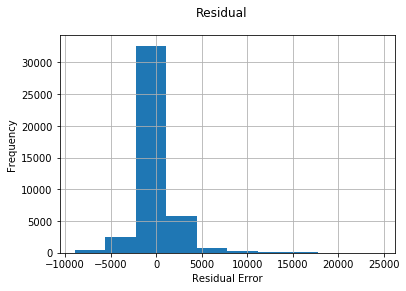

In [14]:
#Vis the residuals
residual_plt = residual(weather_regress, p_sm)
residual_plt.show()

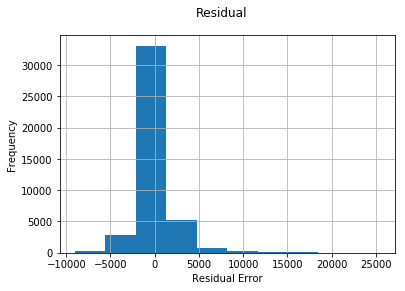

In [15]:
#Vis the residuals of SGD
residual_plt_SGD = residual(weather_regress, p_SGD)
residual_plt_SGD.show()

Now we check the RSS of both regression

In [16]:
def rss(data,predictions):
    mean = np.mean(data['Entries_num_hourly'])
    SST = ((data['Entries_num_hourly'] - mean) ** 2).sum()
    SSReg = ((predictions - data['Entries_num_hourly']) ** 2).sum()
    rss = 1 - np.mean((SSReg / SST))
    return rss

In [17]:
# compute rss for the each model
Rss = rss(weather_regress, p_sm)
Rss_SGD = rss(weather_regress, p_SGD)
print ('Rss for the model by sm is ' + str(Rss))
print ('Rss for the model by SGD is ' + str(Rss_SGD))

Rss for the model by sm is 0.425153343291
Rss for the model by SGD is 0.397692019358


Here we directly look at how fog can influence the number of entries.

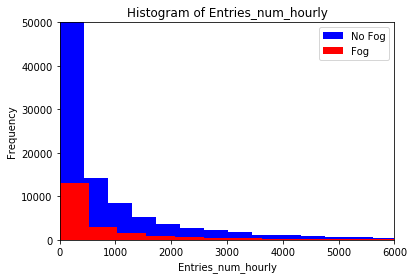

In [18]:
plt.hist([nonfog], bins = 100, color = ['blue'], alpha = 1, label = "No Fog")
plt.hist([fog], bins = 100, color = ['red'], alpha = 1, label = "Fog")
plt.xlabel('Entries_num_hourly')
plt.ylabel('Frequency')
plt.title('Histogram of Entries_num_hourly')
plt.axis([0, 6000, 0, 50000])
plt.legend()
plt.show()

Ggplot is a powerful stetch method to visualize and analyze the data. First, we check a few features to varify relability of data

In [19]:
def vis_with_ggplot(data):
    temp_winspeed = data.loc[:,['meanwindspdi','meantempi']].drop_duplicates()
    temp_winspeed_plot =  ggplot(temp_winspeed, aes('meantempi','meanwindspdi')) + \
    geom_point(colour='black')+\
    ggtitle('Temperature and Windspeed')+ xlab('Temperature') + ylab('Windspeed')

    return temp_winspeed_plot;

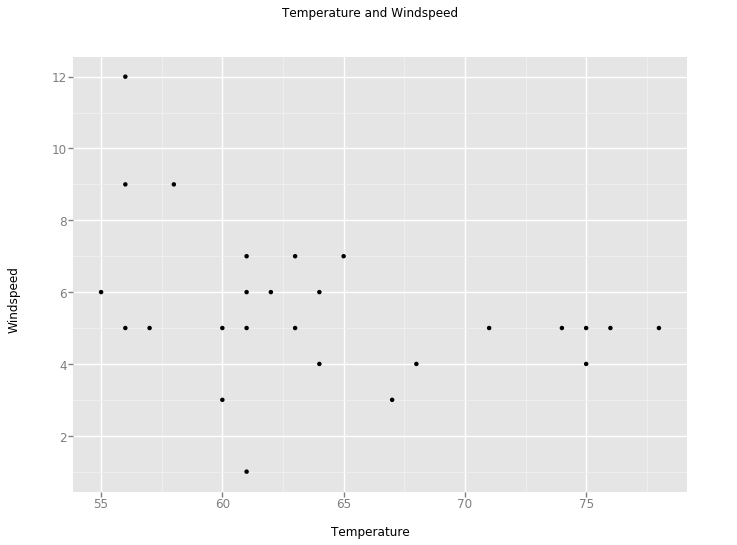

<ggplot: (-9223372036557947879)>

In [20]:
#Visualizations
temp_windspeed_plot = vis_with_ggplot(weather)
temp_windspeed_plot

Now we are going to show the relation between hour of a day and number of entries.

# data = weather_regress[['hour', 'Entries_num_hourly']]
hourly = data.groupby(['hour']).sum()
pd.DataFrame(hourly).reset_index(inplace=True)
ggplot(hourly, aes('hour', 'Entries_num_hourly'))+geom_point()+geom_line()+xlim(0,20)+ylim(0,)+ggtitle('Num of passengers by time of day')+xlab('Hour of day')+ylab('Num of entries per hour')